In [1]:
import os

os.chdir("../../")

import statsmodels.tsa.api as smt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_handling import ingestion

sns.set_theme(context="paper", font_scale=1.15, style="whitegrid")

In [2]:
ts_data = ingestion.read_combined().dropna()

d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


### Train and test set

In [3]:
X = ts_data.drop(columns=["consumption", "temperature"])
y = ts_data["consumption"]

X_train = X[:"2020"]
X_test = X["2021":]
y_train = y[:"2020"]
y_test = y["2021":]

# AutoReg with lag 1 and external regressors
model = smt.AutoReg(y_train, lags=[1, 7], exog=X_train)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                             
===============================================================================
Dep. Variable:             consumption   No. Observations:                 1553
Model:             Restr. AutoReg-X(7)   Log Likelihood              -20341.417
Method:                Conditional MLE   S.D. of innovations         125305.652
Date:                 Thu, 23 Mar 2023   AIC                          40704.835
Time:                         08:40:22   BIC                          40763.612
Sample:                     10-08-2016   HQIC                         40726.698
                          - 12-31-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.911e+06   4.24e+04     45.115      0.000    1.83e+06    1.99e+06
consumption.L1         0.4768      0.010     46.648      0.000       0.457       0.497
consumption.L7         0.0509      0.006      7.928      0.000       0.038       0.063
temperature_capped -7.947e+04   1478.721    -53.745      0.000   -8.24e+04   -7.66e+04
imbalance_prices    -894.0167    464.328     -1.925      0.054   -1804.084      16.050
electricity_price   3815.7135    276.406     13.805      0.000    3273.967    4357.460
crude_oil_price     -341.6421    296.097     -1.154      0.249    -921.982     238.698
eua_price           1272.0394    413.595      3.076      0.002     461.408    2082.671
storage_levels       311.5637     62.648      4.973      0.000     188.776     434.351
weekend            -1.966e+05   7899.495    -24.891      0.000   -2.12e+05   -1.81e+05
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3265           -0.0000j            1.3265           -0.0000
AR.2            1.0276           -1.0328j            1.4570           -0.1254
AR.3            1.0276           +1.0328j            1.4570            0.1254
AR.4           -0.2209           -1.5799j            1.5953           -0.2721
AR.5           -0.2209           +1.5799j            1.5953            0.2721
AR.6           -1.4699           -0.7632j            1.6563           -0.4238
AR.7           -1.4699           +0.7632j            1.6563            0.4238
-----------------------------------------------------------------------------
"""

In [4]:
X_static_regressors = X.copy()
X_static_regressors.loc["2021-01-01":, X_static_regressors.columns.drop("temperature_capped")] = float("nan")
X_static_regressors = X_static_regressors.fillna(method="ffill")

In [5]:
predictions = results.get_prediction(start=0, end="2022-11-28", exog=X_train, exog_oos=X_test)
predictions_static_regressors = results.get_prediction(start=0, end="2022-11-28", exog=X_static_regressors[:"2020"], exog_oos=X_static_regressors["2021":])
predictions_cofindence_intervals = predictions.conf_int()
predictions_static_regressors_confidence_intervals = predictions_static_regressors.conf_int()

modelled_consumption = predictions.predicted_mean
modelled_consumption_static_regressors = predictions_static_regressors.predicted_mean

(0.0, 7000000.0)

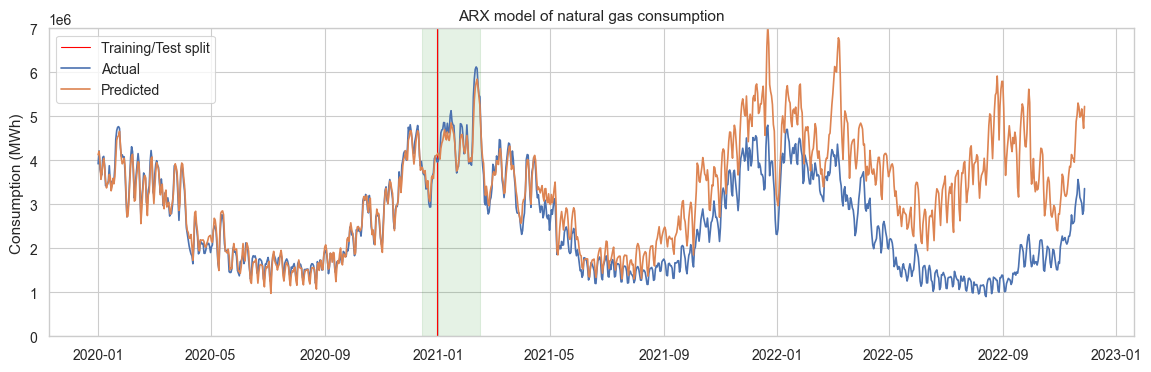

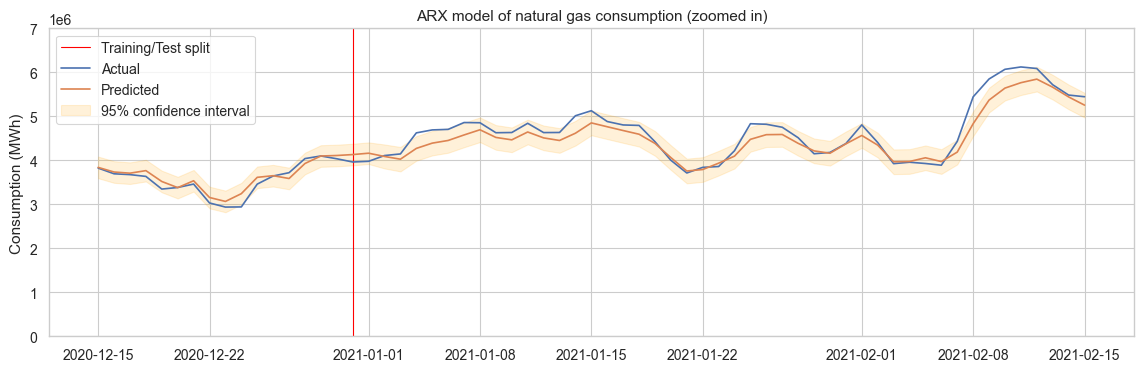

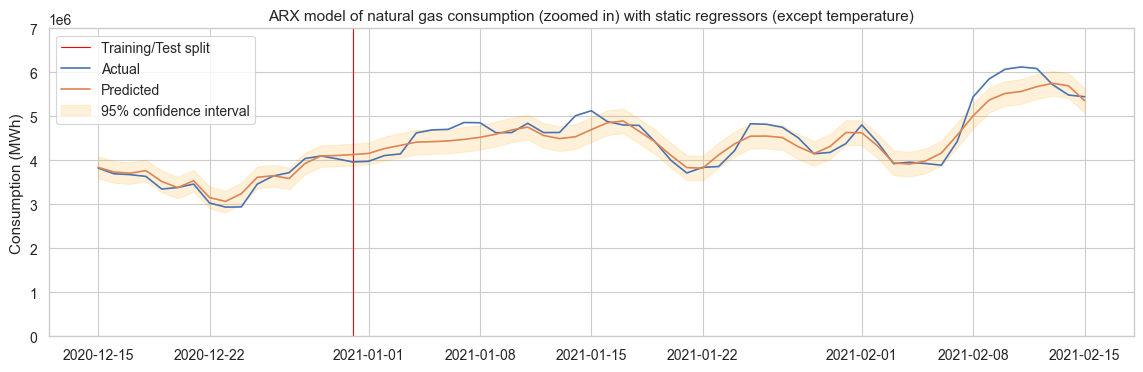

In [8]:
# Plot 1 - multiple years
fig, ax = plt.subplots(figsize=(14, 4))

ax.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax.axvspan(
    pd.Timestamp("2020-12-15"), pd.Timestamp("2021-02-15"), color="green", alpha=0.1
)
ax.plot(y["2020":], label="Actual")
ax.plot(modelled_consumption["2020":], label="Predicted")
ax.set_ylabel("Consumption (MWh)")
ax.legend()
ax.set_title("ARX model of natural gas consumption")
ax.set_ylim(0, 7 * 10**6)

# Plot 2 - zoomed in
fig, ax2 = plt.subplots(figsize=(14, 4))

ax2.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax2.plot(y["2020-12-15":"2021-02-15"], label="Actual")
ax2.plot(modelled_consumption["2020-12-15":"2021-02-15"], label="Predicted")
ax2.fill_between(
    predictions_cofindence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 0].index,
    predictions_cofindence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 0],
    predictions_cofindence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 1],
    color="orange",
    alpha=0.15,
    label="95% confidence interval",
)
ax2.set_ylabel("Consumption (MWh)")
ax2.legend()
ax2.set_title("ARX model of natural gas consumption (zoomed in)")
ax2.set_ylim(0, 7 * 10**6)

# Plot 3 - zoomed in with static regressors
fig, ax3 = plt.subplots(figsize=(14, 4))

ax3.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax3.plot(y["2020-12-15":"2021-02-15"], label="Actual")
ax3.plot(
    modelled_consumption_static_regressors["2020-12-15":"2021-02-15"], label="Predicted"
)
ax3.fill_between(
    predictions_static_regressors_confidence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 0].index,
    predictions_static_regressors_confidence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 0],
    predictions_static_regressors_confidence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 1],
    color="orange",
    alpha=0.15,
    label="95% confidence interval",
)
ax3.set_ylabel("Consumption (MWh)")
ax3.legend()
ax3.set_title(
    "ARX model of natural gas consumption (zoomed in) with static regressors (except temperature)"
)
ax3.set_ylim(0, 7 * 10**6)